<a href="https://colab.research.google.com/github/alpha-davidson/ICTP-Citizen-Science-2023/blob/main/Activity1_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks in TensorFlow's Keras


We will use a dense neural network in Keras to solve a simple regression problem. 
## Learning Task
We will construct a dense neural network to predict the invariant mass of a particle from its energy, momentum, (and charge).

*Note that this task does not require machine learning. We choose a task with a known mapping to help us create, debug, and tune our first neural network.*

## Dataset
This dataset is a collection of simulated particle events from [Pythia](http://home.thep.lu.se/~torbjorn/Pythia.html). The dataset is a 2D array where each row represents one event from an $e^{-} + p$ (electron-proton) collision. This dataset is comprised _only_ of events where exactly 16 particles are produced from an electron-proton collision. Each particle contains $(p_x,p_y,p_z,E,q)$. Each event is therefore represented by 80 numbers. 

**Advanced activity:** There are more interesting event-wise learning tasks using this dataset. Consider crafting your own learning task and target for this data.



## Computational Notes

If this is your first time in a Jupyter-like environment, please read the following carefully:

 - You are in an active kernel
 - Run each cell with `Shift + Enter`
 - You must execute the cells in the order that you want the code to run
 - In Colab, `Runtime`$\rightarrow$`Change runtime type` allows you to utilize GPUs and TPUs. They are unnecessary here, but will become vital in later exercises.


In [1]:
# import the packages we will be using
import numpy as np
import tensorflow as tf
import pylab as plt

2024-06-07 11:05:21.614728: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 11:05:21.617552: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 11:05:21.661112: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 11:05:22.387775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Import data from github. Note: in colab, go to Files and refresh to see file.
# Here I use Linux commands within the notebook to pull the data file and rename it.

# If you are not in an environment that supports the following commands, 
#     paste the url below to download the dataset onto your local machine.

!wget https://github.com/NuclearTalent/MachineLearningECT/blob/master/doc/pub/Day6/data/homogenous-16-particle-events-energy.npy?raw=true
!mv homogenous-16-particle-events-energy.npy?raw=true particle-events.npy

--2024-06-07 11:05:23--  https://github.com/NuclearTalent/MachineLearningECT/blob/master/doc/pub/Day6/data/homogenous-16-particle-events-energy.npy?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/NuclearTalent/MachineLearningECT/raw/master/doc/pub/Day6/data/homogenous-16-particle-events-energy.npy [following]
--2024-06-07 11:05:24--  https://github.com/NuclearTalent/MachineLearningECT/raw/master/doc/pub/Day6/data/homogenous-16-particle-events-energy.npy
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/NuclearTalent/MachineLearningECT/master/doc/pub/Day6/data/homogenous-16-particle-events-energy.npy [following]
--2024-06-07 11:05:24--  https://raw.githubusercontent.com/NuclearTalent/MachineLearningECT/master/doc/pub/Day6/data/homogenous-16

In [3]:
# now we load the data file, which is a numpy array
events = np.load("particle-events.npy")


Recall that each row of this dataset is an entire event. We need each row to represent a training example, which is a single particle.

Using `numpy`'s `reshape` method we can make each row represent one particle. 

In [4]:
# Here we rearrange the data within each of the events to isolate particles

# print("events[0] =\n",events[0])
evt_particles = np.reshape(events, (len(events), 16, 5))

# print("\nevt_particles[0] =\n", evt_particles[0])

# Use another call of reshape to combine all events to have the appropriate shape
# Complete me:
particles = np.reshape(evt_particles, (16, len(evt_particles),5))

# print("\nparticles =\n",particles[:10])
print(particles[0])

[[-0.492933  -0.469448  -2.22871    2.33452   -1.       ]
 [-0.380699   0.859243   0.125686   0.958388  -1.       ]
 [-0.234261   0.933082   1.29211    1.61695   -1.       ]
 ...
 [-0.0106447 -0.0145138 -0.0162003  0.0242159  0.       ]
 [ 0.0117763  0.0197092 -0.0460225  0.0514315  0.       ]
 [ 0.195474   0.132985  -0.464962   0.521617   0.       ]]


These are our training data inputs, but we also must provide the targets, which are the invariant masses of each particle. This is a straightforward computation.

We choose units where $c = 1$:
$$m^2=E^2-||\textbf{p}||^2$$ 
where $m, E$, and $\textbf{p}$ are all in GeV. This is equivalent to 
$$m = \sqrt{E^2 - (p_x^2 + p_y^2 + p_z^2)}$$

**Create an array of your target values.**
Due to insufficient precision, some $m^2$ values for massless particles will come out very slightly negative. These should be treated as zero to avoid `NaN`. I used the `maximum` method from `numpy` to handle this. 

In [5]:
# Complete me:
px = particles[:,:,0]; py = particles[:,:,1]; pz = particles[:,:,2]; E = particles[:,:,3]; q = particles[:,:,4]
print(np.shape(E))
m = np.zeros((16,len(events)))
for k in range(16):
    for i in range(len(events)):
        m[k,i] = np.sqrt(E[k,i]**2 - (px[k,i]**2 + py[k,i]**2 + pz[k,i]**2))
m[np.isnan(m)] = 0     

(16, 35916)


/tmp/ipykernel_13841/3445418509.py:7: RuntimeWarning: invalid value encountered in sqrt
  m[k,i] = np.sqrt(E[k,i]**2 - (px[k,i]**2 + py[k,i]**2 + pz[k,i]**2))


There are several hundred thousand datapoints in this dataset which is overkill for this simple example. Create a test dataset with just 1000 examples.

In [41]:
#Slicing allows you select a subset of an array.
#This can be done like this: smallerArray = largerArray[:100]

#Complete me:
mass_train = m[:,:100]
particles_train = particles[:,:100]
print(np.shape(particles_train[0]))
print(np.shape(mass_train[0]))

(100, 5)
(100,)


Next, make a histogram of the target data to make sure that we are seeing masses of real particles. As this data has limited precision, this will not resolve electrons very well, but protons, pions, and massless particles should be clearly visible.

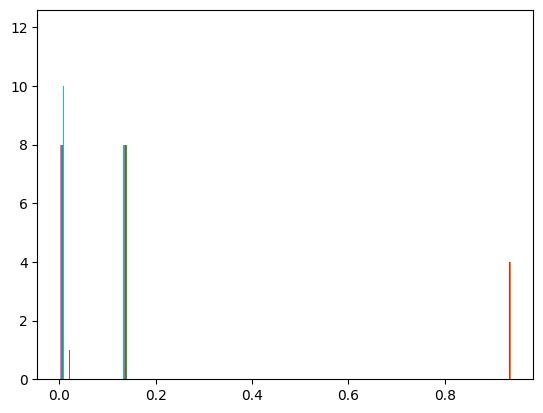

In [14]:
plt.hist(mass_train,bins=100)
# plt.xlim(0,0.2)
plt.show()

Now we can build and train the first neural network. We will start with a network with on hidden layer and 5 neurons, and ReLU activation. 




In [52]:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(5, input_shape=(5,), activation="relu")) #Add a single hidden layer

# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36 (144.00 B)

 Trainable params: 36 (144.00 B)

 Non-trainable params: 0 (0.00 B)

To start, train for 30 epochs with a batch size of 128, an Adam optimizer with a learning rate of 0.1, using mean squared error loss. **This is not ideal.**

Define your validation split to provide a set of data the model has not used to assess how the model is generalizing. This allows us to monitor overtraining. Setting `validation_split=0.2` meaning that $20\%$ of the data will be used for validation. **This is not ideal.**

Information on how to implement these features can be found here:
<https://www.tensorflow.org/api_docs/python/tf/keras>.
Check out Sequential underneath models and Dense under layers.

In [53]:
optimize = tf.keras.optimizers.Adam(0.1) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

In [54]:
mass_input = mass_train[0].reshape(-1, 1)
results = model.fit(particles_train[0], mass_input, epochs=10, batch_size=256, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step - loss: 0.8950 - val_loss: 0.2494
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2905 - val_loss: 0.1986
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4453 - val_loss: 0.0769
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2756 - val_loss: 0.0627
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1604 - val_loss: 0.1037
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1369 - val_loss: 0.1157
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1246 - val_loss: 0.0866
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0895 - val_loss: 0.0450
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0503 - val_loss: 0.0194
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0294 - val_loss: 0.0204


A learning curve is a clearer way to visualize the above training. This helps us determine over and underfitting, which, in turn, helps us tune our model and training.

In [55]:
# helper function for easy plotting
def plot_learning_curve(history):
    plt.plot(history["loss"], label="training loss")
    plt.plot(history["val_loss"], label="validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.legend()
    plt.show()


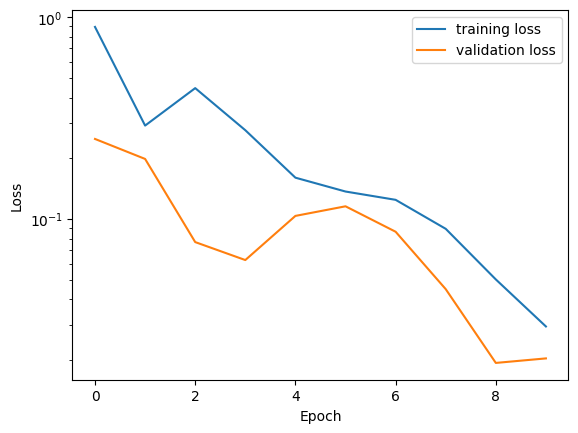

In [56]:
# using the new function
plot_learning_curve(results.history)

## Tuning
The model is learning, but we can do better. 

**At this point, you can play with the above code to change hyperparameters and note changes to your results.**

Alternatively, you can step through tuning this model below.

## Walk-through tuning:
Perhaps we did not have enough model parameters to accurately represent the mapping. Remedy this by increasing the number of hidden neurons to 20.

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step - loss: 0.8142 - val_loss: 21.0944
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 13.0909 - val_loss: 0.7928
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.5556 - val_loss: 7.6646
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 3.6276 - val_loss: 8.2673
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.7570 - val_loss: 4.3202
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.9121 - val_loss: 1.3655
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6126 - val_loss: 0.2619
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2741 - val_loss: 0.2157
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4363 - val_loss: 0.4788
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.6390 - val_loss: 0.6400


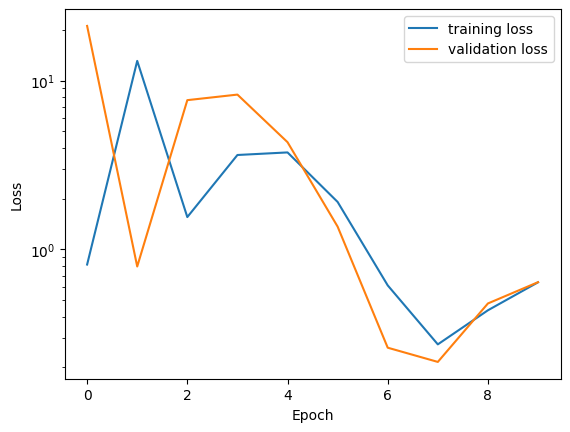

In [63]:
#Use the same code as in the previous cell
#simply change the number of neurons in the hidden layer

# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu")) #Add a single hidden layer

# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
# model.summary()

optimize = tf.keras.optimizers.Adam(0.1) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

mass_input = mass_train[0].reshape(-1, 1)
results = model.fit(particles_train[0], mass_input, epochs=10, batch_size=256, validation_split=0.2)

plot_learning_curve(results.history)

We see that we got little improvement here. Another hyperparameter to adjust is *batch size*, which is the number of training examples used to calculate the gradient on each step. While you may initially think that a higher batch size leads to faster or more accurate training, in practice this is not true. The "noise" that arises from using less training examples at each iteration can actually help find the global minimum of the loss function.
(See here for more info: https://arxiv.org/pdf/1609.04836.pdf)

Try decreasing the batch size to 16.

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9202 - val_loss: 0.4759
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6771 - val_loss: 0.3163
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1778 - val_loss: 0.0443
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1366 - val_loss: 0.0724
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0740 - val_loss: 0.0565
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0568 - val_loss: 0.0370
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0459 - val_loss: 0.0376
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0470 - val_loss: 0.0349
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0387 - val_loss: 0.0324
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0359 - val_loss: 0.0276


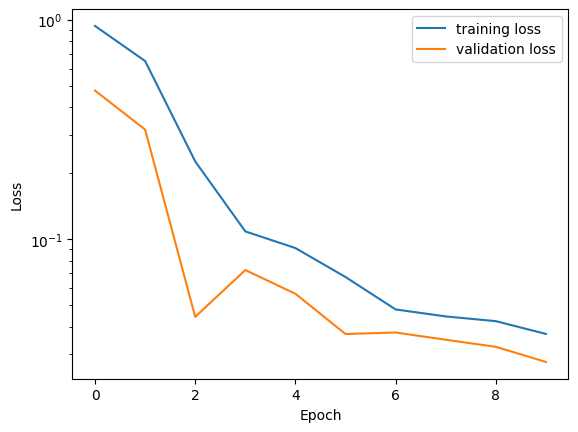

In [59]:
#Complete me:
results = model.fit(particles_train[0], mass_input, epochs=10, batch_size=16, validation_split=0.2)

# using the new function
plot_learning_curve(results.history)

This is starting to do better but has significant room for improvement.

Another hyperparameter to tune is the *learning rate*. 

 - If the learning rate is too high, we are taking too large of a step in the gradient descent at each iteration and will miss narrow minima in the loss function. 
 - If the learning rate is too small, then we are not traveling far enough in each iteration and we will take far too long to reach a minimum. 

Perhaps the learning rate is too high and the network can't fine tune. Try decreasing the learning rate to 0.001.

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.7593 - val_loss: 16.8356
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.9660 - val_loss: 14.8679
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8098 - val_loss: 13.2081
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0903 - val_loss: 11.7733
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6170 - val_loss: 10.4698
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6898 - val_loss: 9.2689
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1741 - val_loss: 8.2548
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8210 - val_loss: 7.2887
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.5970 - val_loss: 6.4496
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3187 - val_loss: 5.7805


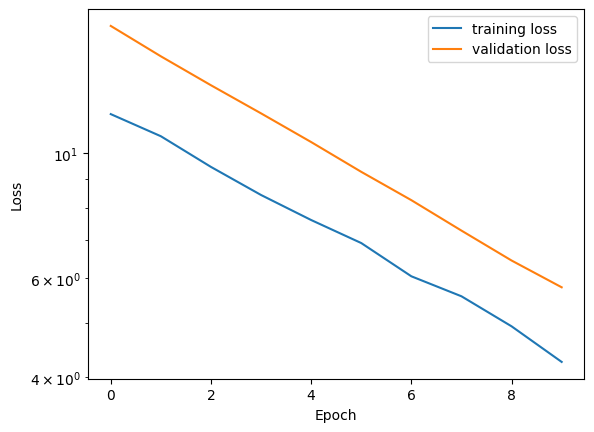

In [64]:

# Complete me:

# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu")) #Add a single hidden layer

# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

mass_input = mass_train[0].reshape(-1, 1)
results = model.fit(particles_train[0], mass_input, epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)

This is not really that much better, but now there is evidence of *overtraining* or *overfitting* -- the training loss is so much lower than the validation loss. 

A common fix to this is adding *dropout layers*. Try adding a dropout layer with dropout rate of 0.5. <https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout>

You can also try batch normalization: <https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization>

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 26.3588 - val_loss: 41.5637
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.0647 - val_loss: 39.3786
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.4096 - val_loss: 37.5917
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.7709 - val_loss: 35.8321
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 31.5266 - val_loss: 33.8447
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.3221 - val_loss: 32.1281
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.3956 - val_loss: 30.3868
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31.1070 - val_loss: 28.6916
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4050 - val_loss: 27.2298
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.6654 - val_loss: 25.8256


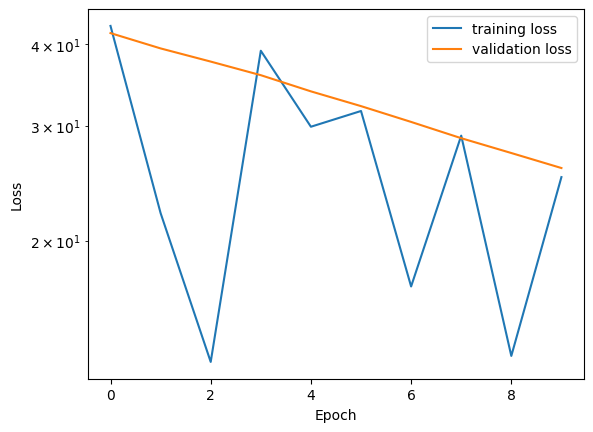

In [66]:
#Dropout layers are located under tf.keras.layers. 
#They take the dropout rate as their only argument.
#BatchNormalization layers are also under tf.keras.layers, and in the simplest use case, take no arguments

#Complete me:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu")) #Add a single hidden layer

# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
# model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

mass_input = mass_train[0].reshape(-1, 1)
results = model.fit(particles_train[0], mass_input, epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)

This clearly stopped the overtraining problem, but it still isn't training well. Now, try training on the full dataset with a more reasonable validation split of 0.2. Use a single hidden layer with 20 neurons, a learning rate of 0.001, and a batch size of 256. Just run it for 10 epochs.

/home/dhoulihan/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 813us/step - loss: 0.7897 - val_loss: 0.0158
Epoch 2/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 0.0143 - val_loss: 0.0110
Epoch 3/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - loss: 0.0110 - val_loss: 0.0101
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step - loss: 0.0100 - val_loss: 0.0094
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step - loss: 0.0103 - val_loss: 0.0088
Epoch 6/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 821us/step - loss: 0.0089 - val_loss: 0.0085
Epoch 7/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step - loss: 0.0087 - val_loss: 0.0076
Epoch 8/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - loss: 0.0077 - val_loss: 0.0071
Epoch 9/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step - loss: 0.0076 - val_loss: 0.0064
Epoch 10/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 829us/step - loss: 0.0066 - val_loss: 0.0057


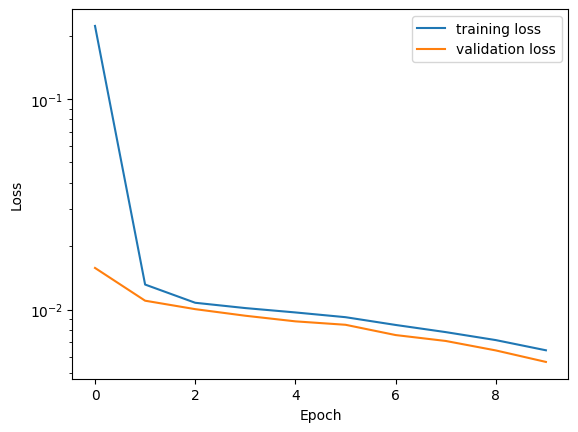

In [67]:
#Complete me:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu")) #Add a single hidden layer

# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

# data I want to use

results = model.fit(particles[0], m[0], epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)

This clearly resulted in a significant improvement and shows how important having a large enough dataset is. Moving on to the choice in activation functions, ReLU is not the only available choice, although it is one of the most popular ones currently. Try training a network using a sigmoid or tanh activation function.

/home/dhoulihan/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_83 (Dense)                │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 827us/step - loss: 0.1182 - val_loss: 0.0217
Epoch 2/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - loss: 0.0202 - val_loss: 0.0182
Epoch 3/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 0.0179 - val_loss: 0.0157
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 0.0148 - val_loss: 0.0114
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 0.0115 - val_loss: 0.0101
Epoch 6/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step - loss: 0.0099 - val_loss: 0.0096
Epoch 7/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 0.0104 - val_loss: 0.0094
Epoch 8/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - loss: 0.0091 - val_loss: 0.0090
Epoch 9/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - loss: 0.0094 - val_loss: 0.0088
Epoch 10/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - loss: 0.0094 - val_loss: 0.0088


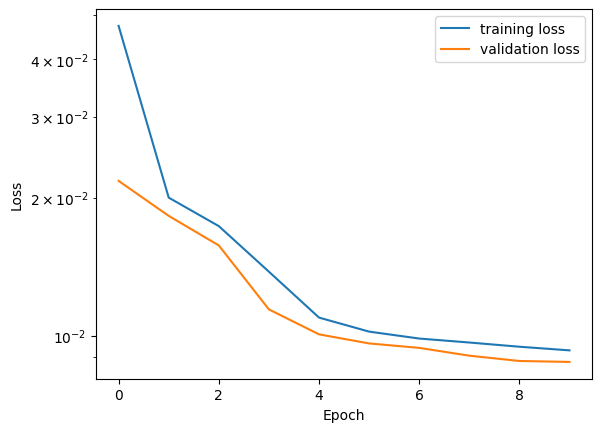

In [86]:
#Simply change relu to sigmoid or tanh to change the activation function

#Complete me:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="sigmoid")) #Add a single hidden layer

# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
# model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

# mass_input = mass_train[0].reshape(-1, 1)
results = model.fit(particles[0], m[0], epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)



Next, try adding 2 new hidden layers to the network. Use the ReLU activation function.

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 981 (3.83 KB)

 Trainable params: 981 (3.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 966us/step - loss: 0.1339 - val_loss: 0.0062
Epoch 2/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 924us/step - loss: 0.0055 - val_loss: 0.0038
Epoch 3/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 921us/step - loss: 0.0040 - val_loss: 0.0026
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 922us/step - loss: 0.0032 - val_loss: 0.0033
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 6/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step - loss: 0.0025 - val_loss: 0.0017
Epoch 7/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 919us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 8/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 910us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 956us/step - loss: 0.0014 - val_loss: 0.0010


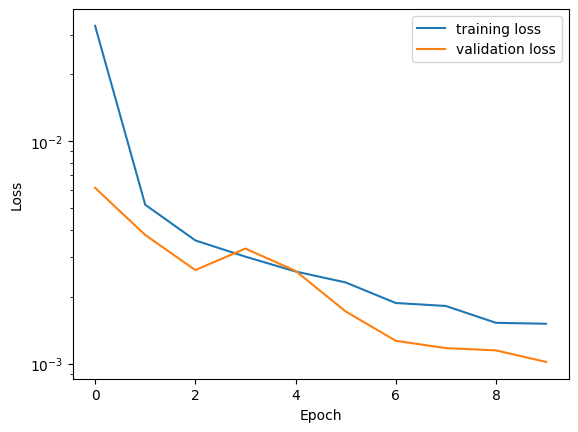

In [87]:
#Complete me:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu")) #Add a single hidden layer
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu"))
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu"))
# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

results = model.fit(particles[0], m[0], epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)


Clearly, adding more layers helps improve the quality of the network. There is a limit to how effective this is though. Try having 5 hidden layers.

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_89 (Dense)                │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,821 (7.11 KB)

 Trainable params: 1,821 (7.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0222 - val_loss: 0.0023
Epoch 2/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 3/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0025 - val_loss: 8.8331e-04
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 6/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0017 - val_loss: 0.0038
Epoch 7/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0022 - val_loss: 9.8891e-04
Epoch 8/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 9/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0015 - val_loss: 0.0017


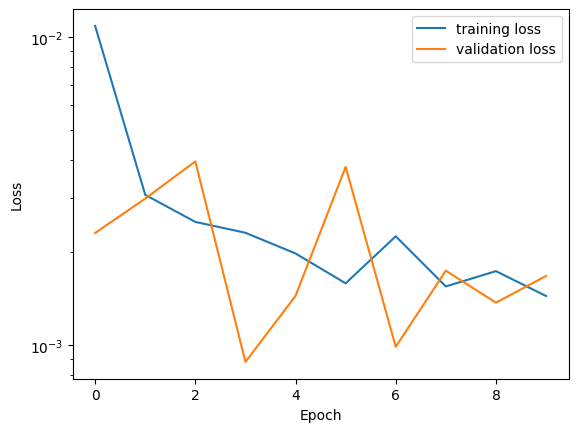

In [88]:
#Complete me:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu")) #Add a single hidden layer
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu"))
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu"))
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu"))
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="relu"))
# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

results = model.fit(particles[0], m[0], epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)

Now, see what happens when you increase the number of neurons per layer from 20 to 50 in the 3 hidden layer model. Consider how they perform compared to ReLU now. 

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 50)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,451 (21.29 KB)

 Trainable params: 5,451 (21.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 980us/step - loss: 0.0190 - val_loss: 0.0032
Epoch 2/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 933us/step - loss: 0.0034 - val_loss: 0.0057
Epoch 3/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 955us/step - loss: 0.0032 - val_loss: 0.0014
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 946us/step - loss: 0.0021 - val_loss: 0.0073
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 6/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 961us/step - loss: 0.0015 - val_loss: 0.0047
Epoch 7/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 949us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 948us/step - loss: 0.0017 - val_loss: 7.3488e-04
Epoch 9/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 941us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 956us/step - loss: 0.0013 - val_loss: 0.0022


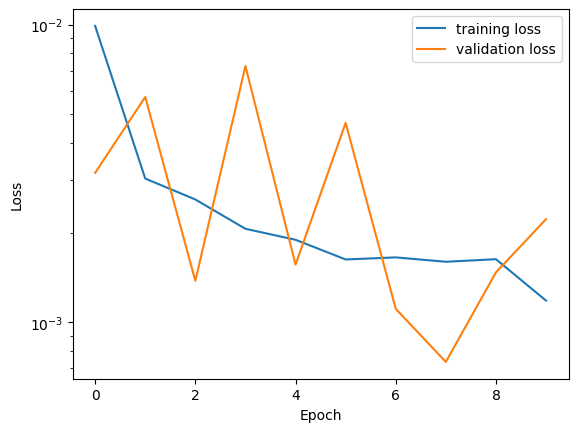

In [89]:
#Complete me:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(50, input_shape=(5,), activation="relu")) #Add a single hidden layer
model.add(tf.keras.layers.Dense(50, input_shape=(5,), activation="relu"))
model.add(tf.keras.layers.Dense(50, input_shape=(5,), activation="relu"))
# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

results = model.fit(particles[0], m[0], epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)

Try using the sigmoid and the tanh activation functions again and compare them to ReLU.

Epoch 1/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0210 - val_loss: 0.0064
Epoch 2/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 3/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 6/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0023 - val_loss: 0.0130
Epoch 7/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 8/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 9/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 10/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0020 - val_loss: 0.0012


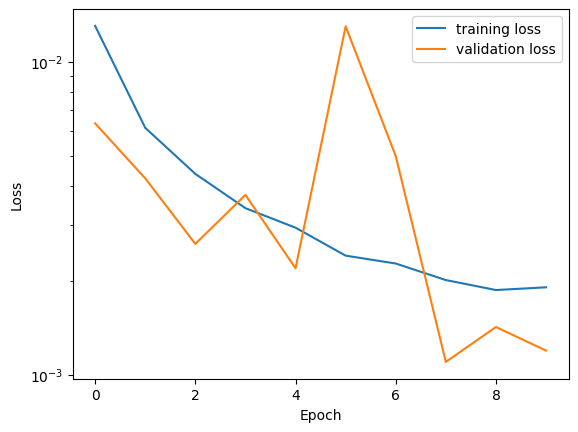

In [90]:
#Complete me:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="tanh")) #Add a single hidden layer
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="tanh"))
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="tanh"))
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="tanh"))
model.add(tf.keras.layers.Dense(20, input_shape=(5,), activation="tanh"))
# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
# model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

results = model.fit(particles[0], m[0], epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)

This difference in performance, especially with the sigmoid function, is known as the vanishing gradient problem. If the value for any one the neurons gets too far away from 0, the gradient for sigmoid and tanh gets really close to 0. This means that for deeper networks it is much more difficult to update the weights in the earlier layers as their gradient is so small. Now, remove the fifth column from the input data, the charge, and see what happens when training. Why do you think including charge has such a large impact, even though it is not required to compute invariant mass?

Epoch 1/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0712 - val_loss: 0.0124
Epoch 2/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0094 - val_loss: 0.0068
Epoch 3/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0075 - val_loss: 0.0056
Epoch 4/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0070 - val_loss: 0.0121
Epoch 5/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 6/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 7/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 8/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 9/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 10/10
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0053 - val_loss: 0.0064


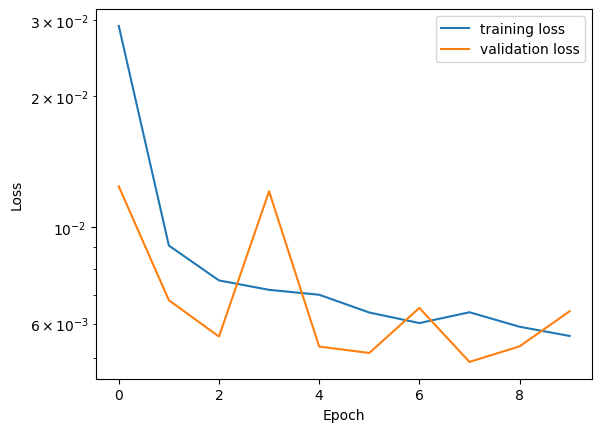

In [93]:
#Complete me:
# Build our model
model = tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(20, input_shape=(4,), activation="relu")) #Add a single hidden layer
model.add(tf.keras.layers.Dense(20, input_shape=(4,), activation="relu"))
model.add(tf.keras.layers.Dense(20, input_shape=(4,), activation="relu"))
model.add(tf.keras.layers.Dense(20, input_shape=(4,), activation="relu"))
model.add(tf.keras.layers.Dense(20, input_shape=(4,), activation="relu"))
# Add the output layer yourself
# No activation function assignment defaults to "linear"
# Complete me:
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

# prints a model summary
# model.summary()

optimize = tf.keras.optimizers.Adam(0.001) # Adam optimizer with a learning rate of 0.1
loss_func = tf.keras.losses.MeanSquaredError() # choosing MSE

# compile model
model.compile(optimizer=optimize,loss=loss_func) 

results = model.fit(particles[0,:,0:4], m[0], epochs=10, batch_size=16, validation_split=0.2)
plot_learning_curve(results.history)

Finally, there are other options for the loss function. Try experimenting with alternatives to mean squared error.

<https://www.tensorflow.org/api_docs/python/tf/keras/losses>

You can also try some other optimizers -- for example, sgd (with and without momentum), rmsprop, adagrad, adadelta, adamax, and nadam. <https://www.tensorflow.org/api_docs/python/tf/keras/optimizers>

